## Neural Enery Models
We want to fit a dataset $\mathcal D = \{x_i\}_{i=1}^n$ with an energy model of form
$$
p_{\theta}(x) = \frac{\exp(f_\theta(x))}{Z_\theta}, ~~~~~~~~ Z_\theta = \int \exp(f_\theta(x)) d x,
$$
where $f_\theta(x)$ is an energy function, and $Z_\theta$ is the partition function.
To make the ensure that the integration is finite, we may assume that
$$
f_\theta(x) = nn_{\theta}(x) - \frac{\|x -\mu\|^2}{2 \sigma^2},
$$
where $nn_\theta(x)$ is a neural network, such as MLP, with trainable weights $\theta$,
 $\mu,\sigma$ can be either a fixed hyperparameter (e.g., $\mu=0$, $\sigma=1$), or trainable.



## Maximum Likelihood Estimator (MLE)

We will try maximum likelihood estimator (MLE). The log-likelihood function is
$$
\ell(\theta; \mathcal D) =  \mathbb E_{x\sim \mathcal D} [\log p_\theta(x)] =  
\mathbb E_{x\sim \mathcal D} [f_\theta(x)] - \log Z_\theta.
$$
Taking the gradient:
$$
\nabla_\theta \ell(\theta; \mathcal D) =  
\mathbb E_{x\sim \mathcal D} [\nabla_\theta f_\theta(x)] - \mathbb E_{x\sim p_\theta}[\nabla_{\theta} f_\theta(x)].
$$
Assume we draw a sample $\hat{\mathcal D}_{\theta}\overset{def}{=}\{\hat x_i\}_{i=1}^n$ from $p_\theta$. The gradient can be estimated via
$$
\nabla_\theta \ell(\theta; \mathcal D)
\approx
\mathbb E_{x\sim \mathcal D} [\nabla_\theta f_\theta(x)] - \mathbb E_{\hat x \sim \hat{\mathcal D}_\theta}[\nabla_{\theta} f_\theta(\hat x)].  
$$
In practice, however, we need to find approximate ways to draw $\hat{\mathcal D_\theta}$. In the toy example below, we will try a brute force way where we partition the space on grids and draw sample on the grids. This only works for low dimensional cases.

Langevin dynamics is an approximate method for sampling from an energy model. Starting from an initialization $x_0$, it performs iterative updates:
$$
x^{t+1} \gets x^t +\frac{\epsilon}{2} \nabla_x \log f_\theta(x^t) + \sqrt{\epsilon} \xi^t,~~~~~~~~ \xi^t\overset{iid}{\sim }\mathcal N(0, I),
$$
where $\epsilon$ is a small step size. It is expected that $x^t$ approximately follows $p_\theta$ when $t$ is large and $\epsilon$ is small.


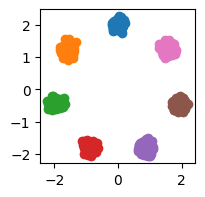

In [2]:
#@title Generate 2D GMM Dataset
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import namedtuple

DataInfo = namedtuple('data_info', ['centers', 'cluster_idx'])
def sample_circular_gmm(batch_size, num_modes=4, radius=2.0, std=0.1):
    angles = torch.linspace(0, 2 * torch.pi, num_modes+1)[:-1] + torch.pi/2
    centers = torch.stack([radius * torch.cos(angles), radius * torch.sin(angles)], dim=1)
    cluster_idx = torch.randint(0, num_modes, (batch_size,))
    selected_centers = centers[cluster_idx]
    batch_data = selected_centers + std * torch.randn(batch_size, 2)

    data_info = DataInfo(centers=centers, cluster_idx=cluster_idx)
    return batch_data, data_info

# Visualize the data
data_points, data_info = sample_circular_gmm(1000, num_modes=7)

plt.figure(figsize=(2, 2))
for i in range(len(data_info.centers)):
    idx = (data_info.cluster_idx == i)
    plt.scatter(data_points[idx, 0], data_points[idx, 1])


logZ, calculated by grid estimation: 6.59


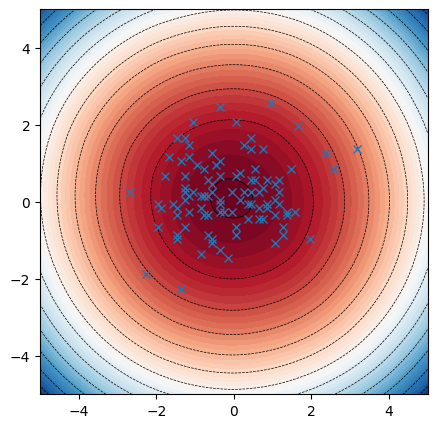

In [3]:
#@title Energy Model, implemented brute force sampling.
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import math

class EnergyModel(nn.Module):
    def __init__(self, model, input_dim):
        super(EnergyModel, self).__init__()
        self.energy = model  #  the negative energy
        self.temperature = 1.0

        # add a learnable gaussian prior term to the energy function
        self.mean_prior = nn.Parameter(torch.zeros(input_dim))
        self.inv_std_prior = nn.Parameter(torch.ones(input_dim))
        self.energy_grid_cache = None

    def neg_log_gaussian_prior(self, x):
        # (x-mu)^2/(2sigma^2)
        return torch.sum((self.inv_std_prior[None,:]*(x-self.mean_prior[None,:]))**2/2,dim=-1, keepdim=True)

    def forward(self, x):
        # total energy = (neural energy + .5*(inv_std*(x-mu))**2)/temperature
        return (self.energy(x) - self.neg_log_gaussian_prior(x))/self.temperature


    # calculating logZ by grid sum
    def logZ_2D_grid(self,  x_range=torch.linspace(-5, 5, 100), y_range=torch.linspace(-5, 5, 100)):
        X, Y, Z = self.update_energy_2D_grid(x_range=x_range, y_range=y_range)
        logZ = torch.logsumexp(Z.flatten(), dim=0) # correct upto a constant
        return logZ

    # Evaluate the energy model on the grid, and save it in cache (only applies to 2D)
    def update_energy_2D_grid(self, x_range=torch.linspace(-5, 5, 100), y_range=torch.linspace(-5, 5, 100)):
        X, Y = torch.meshgrid(x_range, y_range, indexing='ij')
        input_grid = torch.stack([X.flatten(), Y.flatten()], dim=1)  # Reshape to (N, dim)
        Z = self(input_grid).reshape(X.shape)
        self.energy_grid_cache = [X,Y,Z]
        return X, Y, Z

    # get cached energy
    def retrieve_energy_2D_grid(self, x_range=torch.linspace(-5, 5, 100), y_range=torch.linspace(-5, 5, 100)):
        if self.energy_grid_cache is None:
            X,Y,Z = self.update_energy_2D_grid()
        else:
            X,Y,Z = self.energy_grid_cache
        return X, Y, Z

    # plot energy contour
    @torch.no_grad()
    def plot_energy_2D_contour(self, x_range=torch.linspace(-5, 5, 100), y_range=torch.linspace(-5, 5, 100)):
        X, Y, Z = self.retrieve_energy_2D_grid(x_range, y_range)
        plt.contour(X.detach().cpu(), Y.detach().cpu(), Z.detach().cpu(), levels=14, linewidths=0.5, colors='k')
        plt.contourf(X.detach().cpu(), Y.detach().cpu(), Z.detach().cpu(), levels=50, cmap='RdBu_r')

    # sampling from the energy model on the grid (as an approximation)
    @torch.no_grad()
    def sampling_2D_grid(self, num_samples, x_range=torch.linspace(-5, 5, 100), y_range=torch.linspace(-5, 5, 100)):
        X, Y, Z = self.retrieve_energy_2D_grid(x_range=x_range, y_range=y_range)
        prob = torch.softmax(Z.flatten(), dim=0)
        index = torch.multinomial(prob, num_samples=num_samples)
        return torch.stack([X.flatten()[index], Y.flatten()[index]], dim=1)

mlp = nn.Sequential(
    nn.Linear(2, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 1))
model = EnergyModel(mlp, input_dim = 2)
#
logZ = model.logZ_2D_grid()

print(f'logZ, calculated by grid estimation:{logZ: .2f}')

plt.figure(figsize=(5,5))

model.plot_energy_2D_contour()

x_grid_sample = model.sampling_2D_grid(100)
plt.plot(x_grid_sample[:,0], x_grid_sample[:,1], 'x')
plt.show()


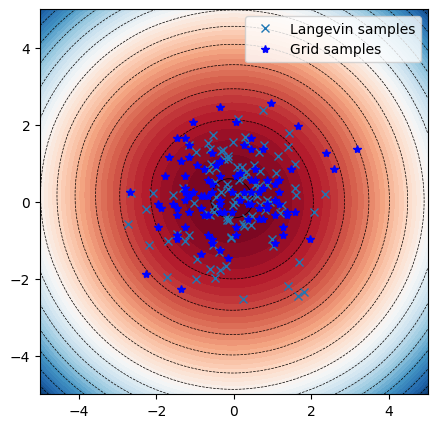

In [4]:
#@title Langevin sampler (Please complete)

def langevin_sampler(model, x0,  num_steps=100, step_size=0.01, record_traj = False):
    x = x0.detach().requires_grad_(True)  # Ensure x requires grad for sampling
    traj = [x.detach()]
    for iter in range(num_steps):
      grad_energy = torch.autograd.grad(model(x).sum(), x)[0]
      ############################
      # write the update of Langevin sampler here
      # x = x + ....
      ############################
      x = x + step_size/2 * grad_energy + (step_size ** 0.5) * torch.randn_like(x)
      if record_traj: traj.append(x.detach())

    if record_traj:
      return x.detach(), torch.stack(traj)
    else:
      return x.detach()

x0 = torch.randn(100,2)
x_langevin = langevin_sampler(model, x0,  num_steps=100, step_size=0.01).detach()

plt.figure(figsize=(5,5))
model.plot_energy_2D_contour()
plt.plot(x_langevin[:,0], x_langevin[:,1], 'x', label='Langevin samples')
plt.plot(x_grid_sample[:,0], x_grid_sample[:,1], 'b*', label='Grid samples')
plt.legend()
plt.show()


<Figure size 640x480 with 0 Axes>

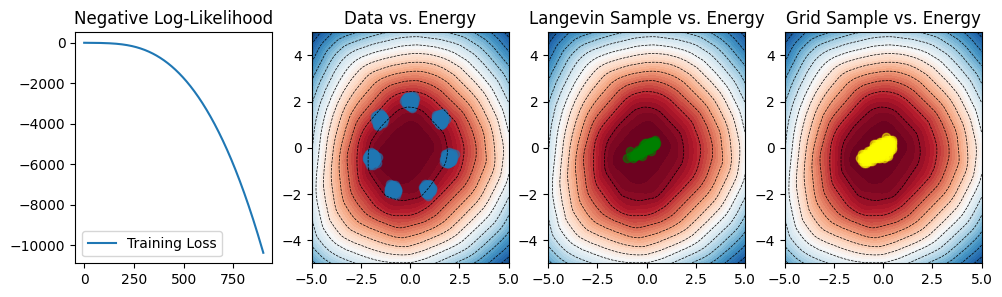

<Figure size 640x480 with 0 Axes>

In [5]:
#@title MLE Training (please complete)

from IPython.display import clear_output

# data
input_dim = 2
data, data_info = sample_circular_gmm(1000, num_modes=7)

# model
mlp = nn.Sequential(
    nn.Linear(input_dim, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 1))
energy_model = EnergyModel(mlp, input_dim)

# set up optimizer
batch_size = 1000
optimizer = optim.Adam(energy_model.parameters(), lr=1e-3)

# training loop
loss_curve = []
for iter in range(1000):

  optimizer.zero_grad()

  data_batch = data[torch.randperm(len(data))[:batch_size]]

  ###########################
  # calculate the negative log likelihood on data_batch
  #loss =  ...
  ###########################
  loss = energy_model.logZ_2D_grid()
  loss.backward()
  optimizer.step()
  loss_curve.append(loss.item())

  # plot
  if iter % 100 == 0:
    clear_output(wait=True)
    KK = 10; kk=1
    plt.figure(figsize=(3*KK,3))

    plt.subplot(1,KK,kk);kk+=1
    plt.plot(loss_curve,label='Training Loss')
    plt.title('Negative Log-Likelihood')
    plt.legend()

    plt.subplot(1,KK,kk);kk+=1
    energy_model.plot_energy_2D_contour()
    plt.scatter(data_batch[:, 0], data_batch[:, 1], alpha=0.5, label='real')
    plt.title('Data vs. Energy')

    plt.subplot(1,KK,kk);kk+=1
    x0 = torch.randn((100,2))
    energy_model.temperature = 1.0
    data_langevin, traj = langevin_sampler(energy_model, x0,  num_steps=1000, step_size=0.001, record_traj = True)
    energy_model.plot_energy_2D_contour()
    plt.scatter(data_langevin[:, 0], data_langevin[:, 1], alpha=0.5, label='real', color='green')
    plt.title('Langevin Sample vs. Energy')

    plt.subplot(1,KK,kk);kk+=1
    energy_model.plot_energy_2D_contour()
    data_grid = energy_model.sampling_2D_grid(100)
    plt.scatter(data_grid[:, 0], data_grid[:, 1], alpha=0.5, label='real', color='yellow')
    plt.title('Grid Sample vs. Energy')

    plt.show()
    plt.suptitle(f'iter={iter}')
